# FUNGI

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import packages
import os
import qiime2 as q2
import pandas as pd
import dokdo
import matplotlib.pyplot as plt
from qiime2.plugins import feature_classifier
from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import filter_seqs
from qiime2.plugins.metadata.visualizers import tabulate

In [3]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [4]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

## TAXONOMIC ANALYSIS 

In [5]:
# load classifier data, bacteria classifier classifier-B-341F_802R, reference reads ref-seqs_341F_802R, reference taxonomy silva-138-99-tax
classifier = q2.Artifact.load(f'{WORKDIR}/database/200204UNITE/developer/whole.length.classifier.qza')
reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200204UNITE/developer/dynamic_otus.filtered.qza')
reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200204UNITE/developer/dynamic_taxonomy.filtered.qza')

In [6]:
# model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [7]:
# choose model, run for each model_name
model_name = "hybrid"
model = models[model_name]

In [8]:
# classify the seqences using different classifiers
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [9]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [10]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save(f'./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: fe1f54a6-c273-479a-85c4-7c955ef7bae9>

In [11]:
# choose a classifier
model_name = "vsearch"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [12]:
# load classification resuls as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: 13d6fc12-504d-416d-99d9-b0ae30705615>

In [13]:
# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: 6f9c92fe-5fdd-4824-94e5-21ee6d701689>

### FILTER BY TAXONOMY

In [14]:
# filter denoisetable, keep only d__Fungi
denoisetable_fun = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'k__Fungi'
)
denoisetable_fun.filtered_table.save('./results/denoisetable_fun.qza')

'./results/denoisetable_fun.qza'

In [15]:
# filter rep_seqs, keep only d_Baceria
rep_seqs_fun = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'k__Fungi'
)
rep_seqs_fun.filtered_sequences.save('./results/rep_seqs_fun.qza')

'./results/rep_seqs_fun.qza'

### TAXA PER SPECIMEN

In [16]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_fun.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [17]:
# define function extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

In [18]:
### VISUALIZATIONS# choose a sample 
# run once for each sample
subject = 'P22A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__'))
custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
# print(taxa_per_species.to_latex())
taxa_per_species

P22A
Domain Phylum        Class           Order             Family              Genus               Species        
/      Ascomycota    Dothideomycetes Capnodiales       Mycosphaerellaceae  Ramularia           /          20.0
                                     Dothideales       Aureobasidiaceae    Aureobasidium       /         311.0
                                                       Dothioraceae        Dothiora            /          55.0
                     Eurotiomycetes  Chaetothyriales   Herpotrichiellaceae Phialophora         /           4.0
                                     Eurotiales        Aspergillaceae      Penicillium         /           1.0
                     Saccharomycetes Saccharomycetales Dipodascaceae       /                   /          27.0
                                                       Pichiaceae          Saturnispora        /         158.0
                                                       Saccharomycetaceae  Saccharomyces       /           4.0
                     Sordariomycetes Hypocreales       Cordycipitaceae     Lecanicillium       /          36.0
                                                       Hypocreaceae        Trichoderma         /          25.0
                                                       Nectriaceae         Fusarium            /           2.0
                                                                           Fusicolla           /         392.0
                                     Xylariales        /                   /                   /         582.0
                     Taphrinomycetes Taphrinales       Protomycetaceae     Saitoella           /           1.0
       Basidiomycota Agaricomycetes  Cantharellales    Ceratobasidiaceae   Rhizoctonia         /         527.0
                                     Polyporales       Fomitopsidaceae     Skeletocutis        /          21.0
                                                       Meripilaceae        /                   /        4104.0
                                                       Polyporaceae        Trametes            /        1136.0
                     Pucciniomycetes Pucciniales       Cronartiaceae       /                   /         123.0
                     Tremellomycetes Trichosporonales  Trichosporonaceae   Cutaneotrichosporon /        3802.0
                     Wallemiomycetes Wallemiales       Wallemiaceae        Wallemia            /          74.0

### VISUALIZATIONS

In [19]:
# visualise classifications
taxa_bar_plot = barplot(
    table = denoisetable_fun.filtered_table,
    taxonomy = taxonomy,
    metadata = sample_metadata
).visualization

In [20]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save(f'{WORKDIR}/proteus_all/fungi/results/taxa_bar_plots.qzv')

'/home/nezapa/qiime-thesis/proteus_all/fungi/results/taxa_bar_plots.qzv'

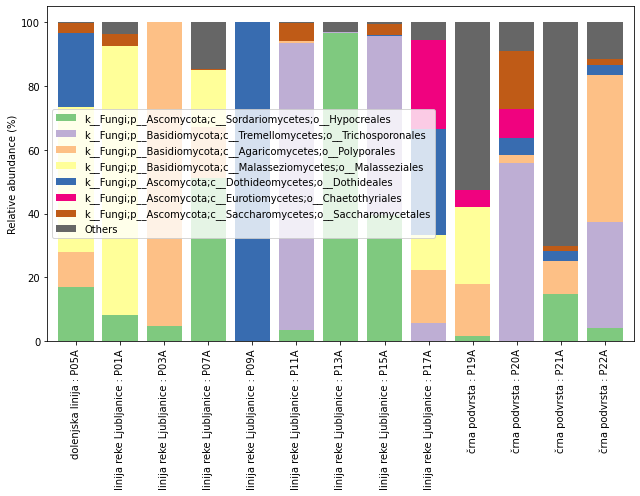

In [21]:
# taxa abundance plot with dokdo
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    level=4,
    count=8,
    figsize=(9, 7),
    by=['population'],
    label_columns=['population', 'sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

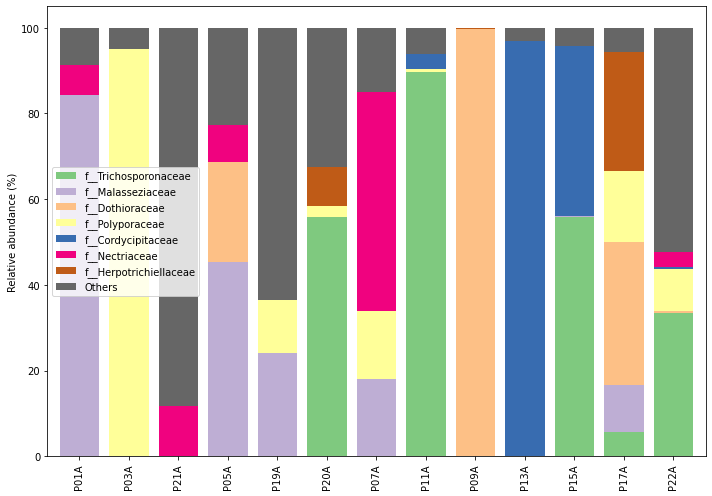

In [22]:
# show 7 most abundant genera plus 'Others' with count = 8
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(10, 7),
    level=5,
    count=8,
    legend_short=True,
    by=['year'],
    label_columns=['sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

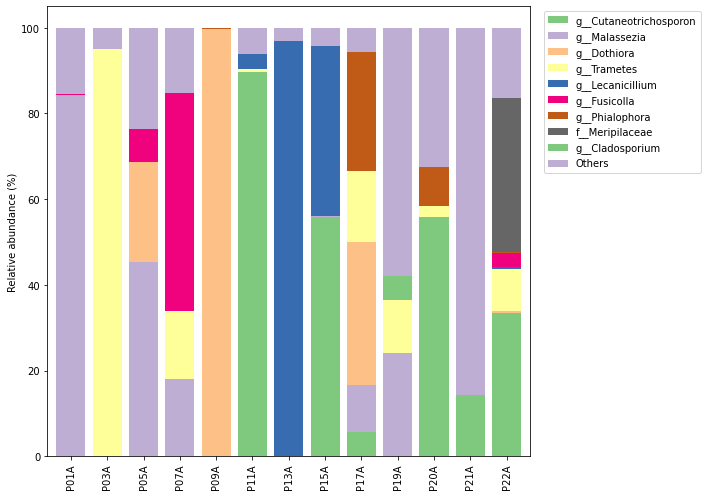

In [23]:
# plot the legent separately
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=10,
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=10,
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

plt.tight_layout()

In [24]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

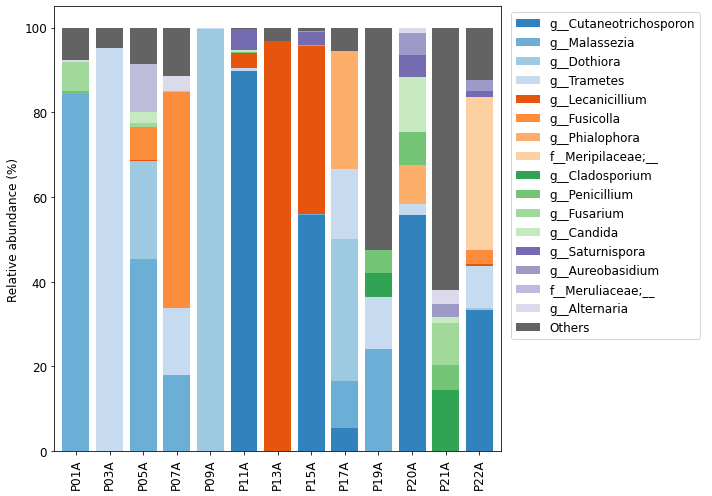

In [25]:
# use a different colour map
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend_short=False
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

# custom properties
ax1.tick_params(labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(12)


ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.savefig('./results/proteus_all_16taxa.png')

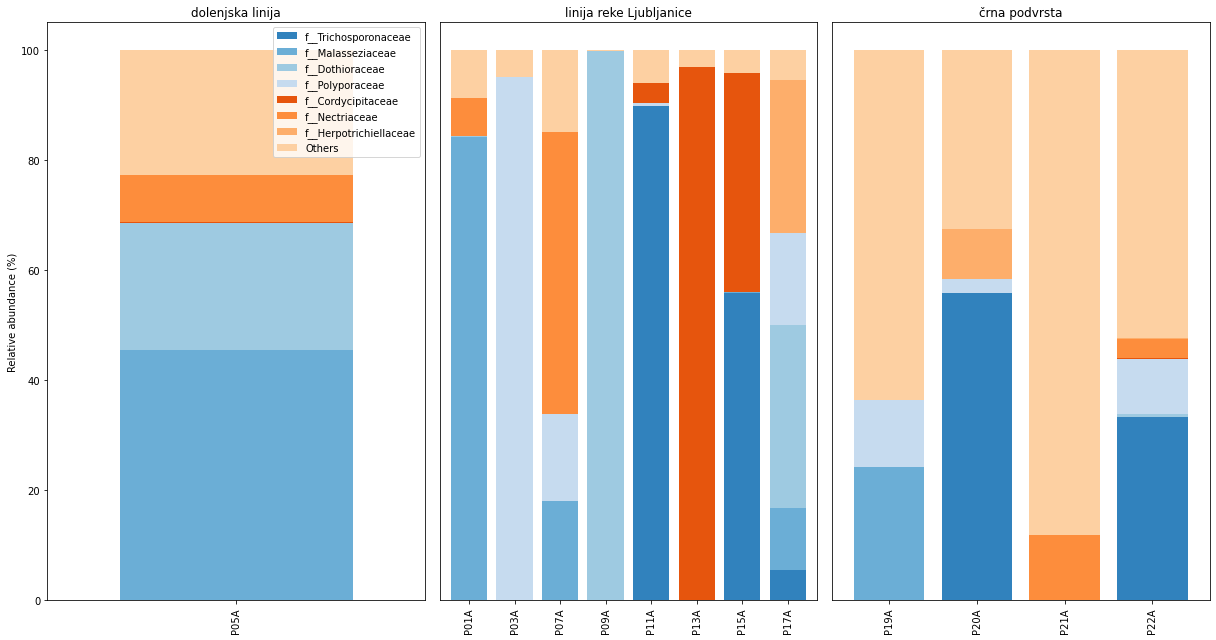

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(17, 9))

groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=5, count=8, sort_by_mean2=False)

for i, group in enumerate(groups):
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=axes[i],
        include_samples={'population': [group]},
        cmap_name='tab20c',
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(group)

    # custom properties
#     axes.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
#     axes.yaxis.label.set_size(15)
    
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations.png')

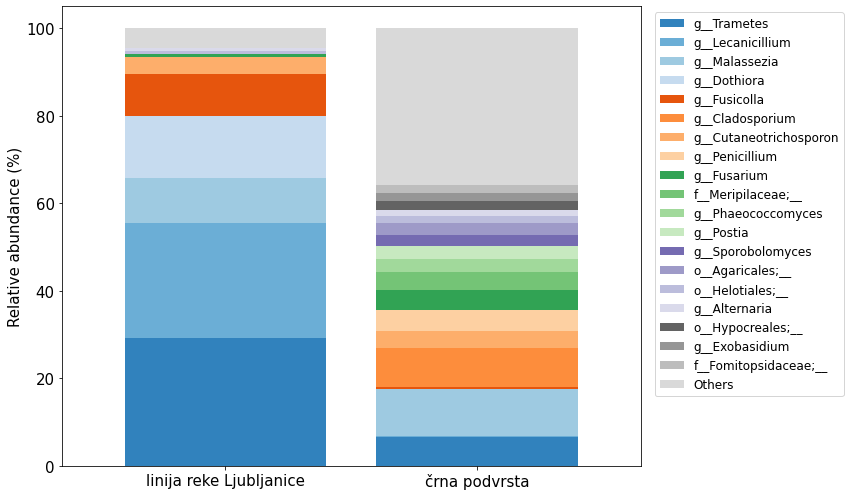

In [27]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend=False,
    cmap_name='tab20c'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend_short=False,
    cmap_name='tab20c'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together.png')

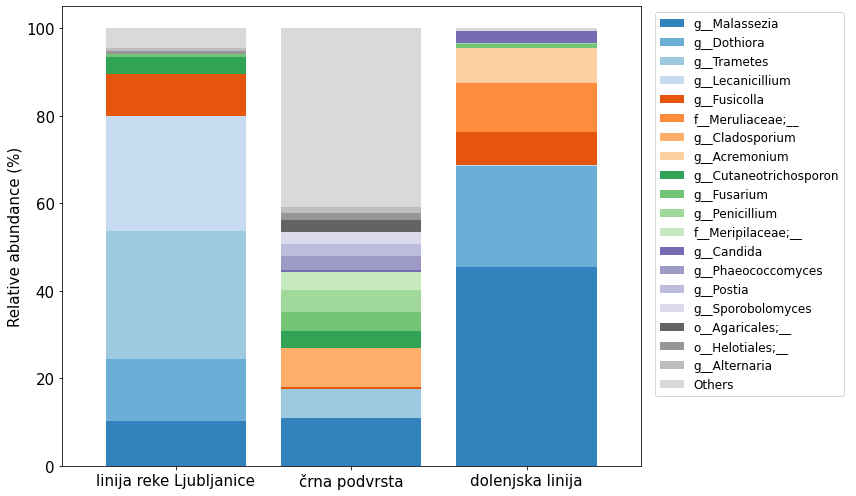

In [28]:
fig, [ax1, ax2,] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta', 'dolenjska linija'],
    figsize=(10, 7),
    legend=False,
    cmap_name='tab20c'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta', 'dolenjska linija'],
    figsize=(10, 7),
    legend_short=False,
    cmap_name='tab20c'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together_all.png')